In [126]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfn import neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross testing of methods

In [ ]:
#X, true_y = load_wine(return_X_y=True)
X, true_y = load_breast_cancer(return_X_y=True)
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

nc = 3
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: float
    instance_label: float

n = 1
cfs = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs.append(CounterfactualData([], index, float(target), label))

[[ 1.55574691  0.60099758  1.55999298  1.58832492  0.39363344  0.88714668
   1.18804295  1.43103938  0.42050829 -0.3052029   1.35878491  0.06495806
   1.32216808  1.34019586 -0.09184133  0.43396315  0.41008254  0.75115285
   0.02142345  0.08876195  1.60075779  0.52769346  1.59017931  1.60779875
   0.34560733  0.63898751  0.85878757  1.24170007  0.30279679  0.0693278 ]
 [-0.20014012  0.17609923 -0.1270001  -0.24480813  0.84759709  1.04602682
   0.77834173  0.48633965  0.75574502  1.22909464 -0.08689227  0.03946137
  -0.01752891 -0.17781661  0.46396399  1.11399406  0.91657959  0.76817598
   0.30356256  1.07218004 -0.11246164  0.30891526 -0.03026721 -0.17757752
   0.95913219  1.19600764  1.04840119  0.72672097  0.79539261  1.42337854]
 [-0.46374165 -0.24858571 -0.4851982  -0.46236145 -0.36346233 -0.58233873
  -0.60928874 -0.61027569 -0.3472521  -0.23505152 -0.42911884 -0.03246555
  -0.43591957 -0.39800819 -0.0965176  -0.44990134 -0.38784734 -0.46087318
  -0.09032072 -0.32337676 -0.5027701

## Baseline

In [128]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 296 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (773) CFs (0)
Re-training surrogate model with data size: 773
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (4) Unique overall (4)
Generated random instances: (3718)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 793
Best instance score 0.0000 (X 0.99838 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 793
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (173) Unique overall (177)
Generated random instances: (3728)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 813
Best instance score 0.0000 (X 0.99838 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 813
--- epoch 3 ----
Generating neig

KeyboardInterrupt: 

## Baycon

In [ ]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['classic_baycon', 'kmeans', 'model_agnostic']
run_mode = modes[2]


if run_mode == modes[0]:
    model = RandomForestClassifier()
    model.fit(X, y)
elif run_mode == modes[1]:
    model = km
elif run_mode == modes[2]:
    model = km
    # model = SpectralClustering(n_clusters=3)
else:
    raise("Invalid baycon mode")

pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(model.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="classification", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[2]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 27 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (770) CFs (93)
Re-training surrogate model with data size: 770
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (86) Unique overall (86)
Generated random instances: (3719)
Predicted top: 20 Counterfactuals: 20
Found new best [1.1930544e+01 1.6874400e+01 1.1750544e+02 4.3428840e+02 1.1590570e-01
 1.0660000e-01 4.5227106e-02 1.9219072e-02 1.8825420e-01 5.6990000e-02
 8.5290000e-01 1.8490000e+00 5.9678880e+00 1.2532800e+01 1.0750000e-02
 2.7220000e-02 5.0810000e-02 1.9110000e-02 1.8584000e-02 4.2170000e-03
 1.4652820e+01 2.3276680e+01 1.3990000e+02 1.4030000e+03 1.3380000e-01
 2.1170000e-01 3.4460000e-01 8.9306280e-02 2.3410000e-01 1.0765818e-01], with fitness score 0.2282 (X 0.89477 Y 0.51 F 0.5), oversampling
Known alternatives: 790
Best instanc

## CFDE

In [ ]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([1.86100000e+01, 2.02500000e+01, 1.22100000e+02, 1.09400000e+03,
        9.48157176e-02, 9.04881882e-02, 6.08800016e-02, 3.25494682e-02,
        1.77951765e-01, 6.35771765e-02, 3.00681647e-01, 1.84900000e+00,
        5.63200000e+00, 9.35400000e+01, 7.17541647e-03, 2.33490235e-02,
        2.84143873e-02, 1.05452329e-02, 2.07137600e-02, 3.75171835e-03,
        2.13100000e+01, 2.72600000e+01, 1.39900000e+02, 8.46451436e+02,
        1.29845529e-01, 2.21074000e-01, 3.44404487e-01, 8.97035082e-02,
        2.82468471e-01, 8.32831059e-02]), array([1.86100000e+01, 2.02500000e+01, 1.22100000e+02, 1.09400000e+03,
        9.48157176e-02, 9.04881882e-02, 6.08800016e-02, 3.25494682e-02,
        1.77951765e-01, 6.35771765e-02, 5.20397388e-01, 1.84900000e+00,
        5.63200000e+00, 9.35400000e+01, 7.17541647e-03, 2.33490235e-02,
        2.84143873e-02, 1.05452329e-02, 2.07137600e-02, 3.75171835e-03,
        2.13100000e+01, 2.72600000e+01, 1.39900000e+02, 8.45064412e+02,


## CFAE

In [ ]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

[CounterfactualData(cf=[array([1.86100000e+01, 2.02500000e+01, 1.22100000e+02, 9.02629995e+02,
        9.44000000e-02, 1.06600000e-01, 1.49000000e-01, 7.73100000e-02,
        1.69700000e-01, 5.69900000e-02, 8.52900000e-01, 1.84900000e+00,
        5.63200000e+00, 9.35400000e+01, 1.07500000e-02, 2.72200000e-02,
        5.08100000e-02, 1.91100000e-02, 2.29300000e-02, 4.21700000e-03,
        2.13100000e+01, 2.72600000e+01, 1.39900000e+02, 1.00760983e+03,
        1.33800000e-01, 2.11700000e-01, 3.44600000e-01, 1.49000000e-01,
        2.34100000e-01, 7.42100000e-02]), array([1.86100000e+01, 2.02500000e+01, 1.22100000e+02, 9.01483593e+02,
        9.44000000e-02, 1.06600000e-01, 1.49000000e-01, 7.73100000e-02,
        1.69700000e-01, 5.69900000e-02, 8.52900000e-01, 1.84900000e+00,
        5.63200000e+00, 9.35400000e+01, 1.07500000e-02, 2.72200000e-02,
        5.08100000e-02, 1.91100000e-02, 2.29300000e-02, 4.21700000e-03,
        2.13100000e+01, 2.72600000e+01, 1.39900000e+02, 9.78555520e+02,


## NeighborSearch

In [ ]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, kmeans=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

ns_cfs

/home/kvist/spe/thesis-gang/code/lib/neighborSearch/cfn.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  score = f_dis / diff


[CounterfactualData(cf=array([[1.650e+01, 1.829e+01, 1.066e+02, 8.381e+02, 9.686e-02, 8.468e-02,
         5.862e-02, 4.835e-02, 1.495e-01, 5.593e-02, 3.389e-01, 1.439e+00,
         2.344e+00, 3.358e+01, 7.257e-03, 1.805e-02, 1.832e-02, 1.033e-02,
         1.694e-02, 2.001e-03, 1.813e+01, 2.545e+01, 1.172e+02, 1.009e+03,
         1.338e-01, 1.679e-01, 1.663e-01, 9.123e-02, 2.394e-01, 6.469e-02],
        [1.624e+01, 1.877e+01, 1.088e+02, 8.051e+02, 1.066e-01, 1.802e-01,
         1.948e-01, 9.052e-02, 1.876e-01, 6.684e-02, 2.873e-01, 9.173e-01,
         2.464e+00, 2.809e+01, 4.563e-03, 3.481e-02, 3.872e-02, 1.209e-02,
         1.388e-02, 4.081e-03, 1.855e+01, 2.509e+01, 1.269e+02, 1.031e+03,
         1.365e-01, 4.706e-01, 5.026e-01, 1.732e-01, 2.770e-01, 1.063e-01],
        [1.646e+01, 2.011e+01, 1.093e+02, 8.329e+02, 9.831e-02, 1.556e-01,
         1.793e-01, 8.866e-02, 1.794e-01, 6.323e-02, 3.037e-01, 1.284e+00,
         2.482e+00, 3.159e+01, 6.627e-03, 4.094e-02, 5.371e-02, 1.813e-02,
 

## Testing

In [ ]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}
nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

methods = [baseLine, Baycon, cfde, cfae, nfs]
results, names = run(methods, centers, X, y)

print("Diversity metric - ")
print("Baseline: " + str(results["Baseline"][0][4]))
print("Baycon: " + str(results["Baycon"][0][4]))
print("CF-DE: " + str(results["CF-DE"][0][4]))
print("CF-AE: " + str(results["CF-AE"][0][4]))
print("NeighborSearch: " + str(results["NeighborSearch"][0][4]))

Diversity metric - 
Baseline: 1.1172215414121296
Baycon: 0.0
CF-DE: 0.0017692257374551294
CF-AE: 1.5947063887494592
NeighborSearch: 3.0512129488714534


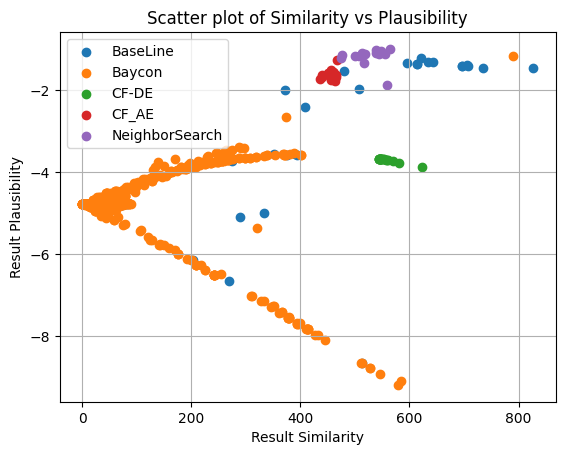

In [ ]:
def plot(f1, f2, results_list, names):
    method_names = ["BaseLine", "Baycon", "CF-DE", "CF_AE", "NeighborSearch"]
    for idx, results in enumerate(results_list):
        result_x = [row[f1] for row in results]
        result_y = [row[f2] for row in results]

        plt.scatter(result_x, result_y, label=f"{method_names[idx]}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

plot(0,2, [results["Baseline"], results["Baycon"], results["CF-DE"], results["CF-AE"], results["NeighborSearch"]], names)

<Axes: >

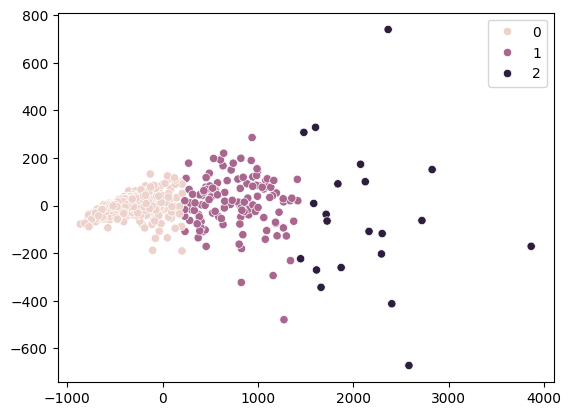

In [ ]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

<Axes: title={'center': 'Instance from cluster 1 into 0'}>

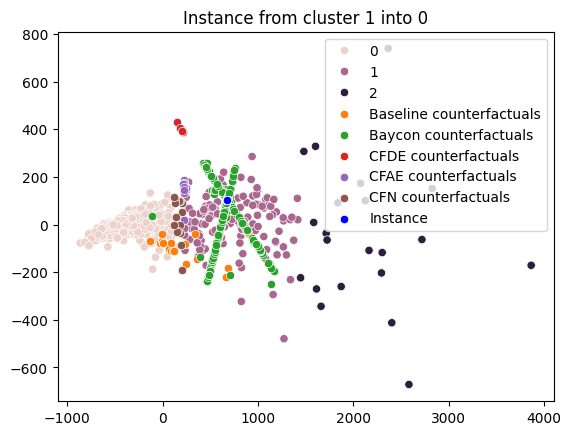

In [ ]:
cf_n = 0
baseline_embed = [pca.transform(v.cf) for v in baseline_cfs][cf_n]
baycon_embed = [pca.transform(v.cf) for v in baycon_cfs][cf_n]
cfde_embed = [pca.transform(v.cf) for v in cfde_cfs][cf_n]
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs][cf_n]
cfn_embed = [pca.transform(v.cf) for v in ns_cfs][cf_n]
instance_embedded = pca.transform(X[[baseline_cfs[cf_n].instance]])

ins_c = baseline_cfs[cf_n].instance_label
target_c = baseline_cfs[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=baseline_embed[:,0], y=baseline_embed[:,1], label="Baseline counterfactuals")
sns.scatterplot(x=baycon_embed[:,0], y=baycon_embed[:,1], label="Baycon counterfactuals")
sns.scatterplot(x=cfde_embed[:,0], y=cfde_embed[:,1], label="CFDE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=cfn_embed[:,0], y=cfn_embed[:,1], label="CFN counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")


## Running time

In [ ]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, kmeans=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 550 Target: 2 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (772) CFs (0)
Re-training surrogate model with data size: 772
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (21) Unique overall (21)
Generated random instances: (3720)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 792
Best instance score 0.0000 (X 0.9998 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 792
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (267) Unique overall (287)
Generated random instances: (3729)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 812
Best instance score 0.0000 (X 0.9998 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 812
--- epoch 3 ----
Generating neig

KeyboardInterrupt: 

## RD-CFAE vs CFAE
*rd is random-direction

In [ ]:
n = 1
cfs_div = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs_div.append(CounterfactualData([], index, float(target), label))

amount = 70

cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf2)
    cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

rd_cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    rd_cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

<Axes: title={'center': 'Instance from cluster 0 into 1'}>

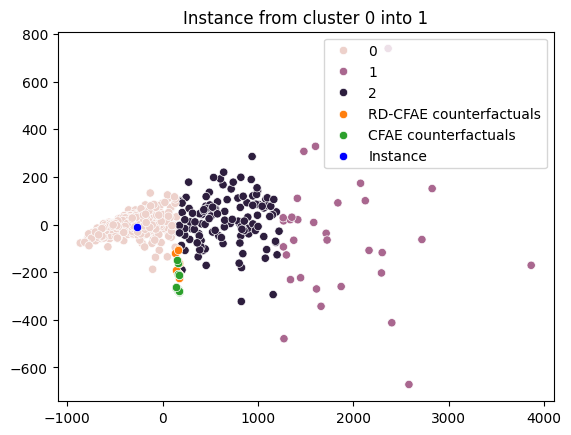

In [ ]:
cf_n = 0
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs_div][cf_n]
rd_cfae_embed = [pca.transform(v.cf) for v in rd_cfae_cfs_div][cf_n]
instance_embedded = pca.transform(X[[cfae_cfs_div[cf_n].instance]])

ins_c = cfae_cfs_div[cf_n].instance_label
target_c = cfae_cfs_div[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=rd_cfae_embed[:,0], y=rd_cfae_embed[:,1], label="RD-CFAE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")